
# Random Forest


# Setup

In [ ]:
#@title Run to Set Up
!pip install -U wget
!rm -rf data.zip data lib
!mkdir lib

import wget
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/lib/config.yaml', 'lib/config.yaml')
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/lib/helper.py', 'lib/helper.py')
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/data.zip', 'data.zip')

import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

Requirement already up-to-date: wget in /usr/local/lib/python3.7/dist-packages (3.2)


In [ ]:
import numpy as np
import collections
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics, exceptions

from lib.helper import load_data
from lib.helper import load_data, config
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
N = 100 # we are selecting first 2500 participant for this tutorial (you can choose upto 10k)
raw_data, df_labels = load_data(N)

Loading files from disk: 100%|██████████| 100/100 [00:00<00:00, 531.15it/s]


In [ ]:
#@title Define preprocessing functions. { display-mode: "form" }
#@markdown - `impute_missing_data(X)`
#@markdown - `normalize_feature_matrix(X)`
#@markdown - `generate_feature_vector(X)`

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def impute_missing_data(X):
    """
    For each feature column, impute missing values  (np.nan) with the
    population mean for that feature.

    Args:
        X: np.array, shape (N, d). X could contain missing values
    Returns:
        X: np.array, shape (N, d). X does not contain any missing values
    """
    return SimpleImputer().fit_transform(X)

from sklearn.preprocessing import MinMaxScaler
def normalize_feature_matrix(X):
    """
    For each feature column, normalize all values to range [0, 1].

    Args:
        X: np.array, shape (N, d).
    Returns:
        X: np.array, shape (N, d). Values are normalized per column.
    """
    return MinMaxScaler().fit_transform(X)

def generate_feature_vector(df):
    """
    Reads a dataframe containing all measurements for a single patient
    within the first 48 hours of the ICU admission, and convert it into
    a feature vector.

    Args:
        df: pd.Dataframe, with columns [Time, Variable, Value]

    Returns:
        a python dictionary of format {feature_name: feature_value}
        for example, {'Age': 32, 'Gender': 0, 'mean_HR': 84, ...}
    """
    static_variables = config['invariant']
    timeseries_variables = config['timeseries']

    # Replace unknown values
    df = df.replace({-1: np.nan})

    feature_dict = {}

    # Split time invariant and time series
    static, timeseries = df.iloc[0:5], df.iloc[5:]
    static = static.pivot('Time', 'Variable', 'Value')

    feature_dict = static.iloc[0].to_dict()
    for variable in timeseries_variables:
        measurements = timeseries[timeseries['Variable'] == variable]['Value']
        feature_dict['mean_' + variable] = np.mean(measurements)

        # NOTE: rand forest did better without these added features:
        # feature_dict['median_' + variable] = np.median(measurements)
        # feature_dict['std_' + variable] = np.std(measurements)
        # feature_dict['count_' + variable] = len(measurements)

        if len(measurements)==0:
          feature_dict['missing_' + variable] = 1
        else:
          feature_dict['missing_' + variable] = 0

    return feature_dict

In [ ]:
features = [generate_feature_vector(df) for _, df in tqdm(sorted(raw_data.items()),desc="generating feature vectors")]

generating feature vectors: 100%|██████████| 100/100 [00:02<00:00, 36.25it/s]


In [ ]:
df_features = pd.DataFrame(features).sort_index(axis=1)
feature_names = df_features.columns.tolist()
X, y = df_features.values, df_labels['In-hospital_death'].values
pd.DataFrame(df_features)

,Age,Gender,Height,ICUType,Weight,mean_ALP,mean_ALT,mean_AST,mean_Albumin,mean_BUN,mean_Bilirubin,mean_Cholesterol,mean_Creatinine,mean_DiasABP,mean_FiO2,mean_GCS,mean_Glucose,mean_HCO3,mean_HCT,mean_HR,mean_K,mean_Lactate,mean_MAP,mean_Mg,mean_NIDiasABP,mean_NIMAP,mean_NISysABP,mean_Na,mean_PaCO2,mean_PaO2,mean_Platelets,mean_RespRate,mean_SaO2,mean_SysABP,mean_Temp,mean_TroponinI,mean_TroponinT,mean_Urine,mean_WBC,mean_pH,missing_ALP,missing_ALT,missing_AST,missing_Albumin,missing_BUN,missing_Bilirubin,missing_Cholesterol,missing_Creatinine,missing_DiasABP,missing_FiO2,missing_GCS,missing_Glucose,missing_HCO3,missing_HCT,missing_HR,missing_K,missing_Lactate,missing_MAP,missing_Mg,missing_NIDiasABP,missing_NIMAP,missing_NISysABP,missing_Na,missing_PaCO2,missing_PaO2,missing_Platelets,missing_RespRate,missing_SaO2,missing_SysABP,missing_Temp,missing_TroponinI,missing_TroponinT,missing_Urine,missing_WBC,missing_pH
0,54.0,0.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,10.500000,NaN,NaN,0.750000,NaN,NaN,14.923077,160.000000,27.000000,32.500000,70.810811,4.200000,NaN,NaN,1.700000,50.147059,71.559118,114.382353,136.500000,NaN,NaN,203.000000,17.428571,NaN,NaN,37.357143,NaN,NaN,171.052632,10.300000,NaN,1,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0,1
1,76.0,1.0,175.3,2.0,76.0,NaN,NaN,NaN,NaN,18.333333,NaN,NaN,1.100000,58.897059,0.560000,13.333333,125.500000,22.333333,28.655556,80.794118,3.900000,NaN,76.940299,2.300000,56.714286,75.308571,112.500000,137.000000,38.857143,210.142857,178.600000,NaN,96.833333,113.411765,36.939130,NaN,NaN,151.560976,11.266667,7.395000,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
2,44.0,0.0,NaN,3.0,56.7,116.0,83.0,199.5,2.5,4.666667,2.9,NaN,0.333333,67.125000,0.500000,5.923077,134.333333,25.000000,28.460000,83.759259,4.260000,1.366667,90.437500,1.720000,79.000000,96.751316,132.263158,138.333333,35.500000,134.500000,89.666667,NaN,95.000000,125.687500,37.800000,NaN,NaN,124.951220,4.700000,7.495000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
3,68.0,1.0,180.3,3.0,84.6,105.0,12.0,15.0,4.4,17.666667,0.2,NaN,0.766667,NaN,NaN,14.944444,117.333333,27.666667,37.442857,70.983333,4.000000,NaN,NaN,2.033333,65.051724,83.885517,121.551724,139.333333,NaN,NaN,330.000000,15.457627,NaN,NaN,36.223077,NaN,NaN,545.833333,9.400000,NaN,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0,1
4,88.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,3.3,35.000000,NaN,NaN,1.000000,NaN,NaN,15.000000,102.500000,19.000000,29.550000,74.958333,4.320000,NaN,NaN,1.550000,45.720930,74.946512,133.395349,139.500000,NaN,NaN,103.000000,19.166667,NaN,NaN,36.880000,NaN,NaN,62.131579,4.300000,NaN,1,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,81.0,0.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,13.000000,NaN,NaN,0.750000,60.830189,0.600000,15.000000,127.500000,23.500000,31.881818,76.685185,3.800000,NaN,90.803922,1.700000,55.750000,75.746250,115.750000,140.500000,45.000000,107.500000,164.000000,15.017857,NaN,143.698113,36.492308,NaN,NaN,88.970588,12.900000,7.380000,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0
96,47.0,0.0,NaN,3.0,116.0,NaN,NaN,NaN,NaN,19.500000,NaN,NaN,0.650000,NaN,0.533333,11.363636,206.000000,29.500000,32.200000,75.947368,4.300000,NaN,NaN,1.800000,46.810811,73.756216,127.648649,137.500000,NaN,NaN,271.000000,NaN,NaN,NaN,37.307692,NaN,NaN,83.200000,10.600000,NaN,1,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,1
97,71.0,0.0,177.8,1.0,96.0,74.0,24.0,59.0,3.6,21.750000,0.7,205.0,0.675000,53.916667,0.812500,13.000000,126.000000,24.500000,32.240000,85.431034,4.066667,NaN,82.267442,2.050000,64.000000,83.890000,123.666667,135.666667,36.50000

In [ ]:
collections.Counter(y)

Counter({-1.0: 87, 1.0: 13})

In [ ]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
sns.pairplot(df_features)


# Impute Missing Data: Categorical and Numerical


In [ ]:
imputed_features = df_features.copy()
imputed_features["ICUType"] = df_features["ICUType"].fillna(df_features["ICUType"].value_counts().idxmax())

In [ ]:
X_imputed = imputed_features.values
X_imputed = impute_missing_data(X_imputed)
pd.DataFrame(X_imputed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,54.0,0.0,170.025553,4.0,81.139001,102.333204,154.656547,226.903678,2.965495,10.500000,1.949921,158.743386,0.750000,59.268353,0.550001,14.923077,160.000000,27.000000,32.500000,70.810811,4.200,2.384591,80.867409,1.700000,50.147059,71.559118,114.382353,136.500000,40.315341,148.536515,203.000000,17.428571,96.628703,118.322015,37.357143,7.008712,1.097129,171.052632,10.300000,7.411695,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,76.0,1.0,175.300000,2.0,76.000000,102.333204,154.656547,226.903678,2.965495,18.333333,1.949921,158.743386,1.100000,58.897059,0.560000,13.333333,125.500000,22.333333,28.655556,80.794118,3.900,2.384591,76.940299,2.300000,56.714286,75.308571,112.500000,137.000000,38.857143,210.142857,178.600000,19.618336,96.833333,113.411765,36.939130,7.008712,1.097129,151.560976,11.266667,7.395000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,44.0,0.0,170.025553,3.0,56.700000,116.000000,83.000000,199.500000,2.500000,4.666667,2.900000,158.743386,0.333333,67.125000,0.500000,5.923077,134.333333,25.000000,28.460000,83.759259,4.260,1.366667,90.437500,1.720000,79.000000,96.751316,132.263158,138.333333,35.500000,134.500000,89.666667,19.618336,95.000000,125.687500,37.800000,7.008712,1.097129,124.951220,4.700000,7.495000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,68.0,1.0,180.300000,3.0,84.600000,105.000000,12.000000,15.000000,4.400000,17.666667,0.200000,158.743386,0.766667,59.268353,0.550001,14.944444,117.333333,27.666667,37.442857,70.983333,4.000,2.384591,80.867409,2.033333,65.051724,83.885517,121.551724,139.333333,40.315341,148.536515,330.000000,15.457627,96.628703,118.322015,36.223077,7.008712,1.097129,545.833333,9.400000,7.411695,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,88.0,0.0,170.025553,3.0,81.139001,102.333204,154.656547,226.903678,3.300000,35.000000,1.949921,158.743386,1.000000,59.268353,0.550001,15.000000,102.500000,19.000000,29.550000,74.958333,4.320,2.384591,80.867409,1.550000,45.720930,74.946512,133.395349,139.500000,40.315341,148.536515,103.000000,19.166667,96.628703,118.322015,36.880000,7.008712,1.097129,62.131579,4.300000,7.411695,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,72.0,1.0,170.200000,2.0,74.900000,102.333204,154.656547,226.903678,2.965495,11.200000,1.949921,158.743386,0.920000,61.555556,0.750000,14.583333,105.250000,25.000000,31.925000,84.718750,4.175,1.100000,72.822581,1.866667,57.266667,72.944000,104.300000,137.000000,39.750000,244.500000,121.250000,19.618336,98.000000,102.142857,37.925000,7.008712,1.097129,168.977273,16.325000,7.365000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2496,47.0,1.0,170.025553,4.0,75.000000,102.333204,154.656547,226.903678,2.965495,30.500000,1.949921,158.743386,1.300000,59.268353,0.550001,15.000000,185.500000,22.000000,36.000000,51.750000,4.150,2.384591,80.867409,1.950000,39.161290,62.989355,110.645161,138.000000,40.315341,148.536515,172.500000,15.483871,96.628703,118.322015,37.310000,7.00

# Normalize Features

In [ ]:
X_imputed = normalize_feature_matrix(X_imputed)
df_imputed = pd.DataFrame(X_imputed)
df_imputed.columns = feature_names

# Implement Categorical Feature ICUType


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df_imputed[['ICUType']]).toarray())
enc_df.columns = ["CoronaryICU", "CardiacICU", "MedicalICU", "SurgicalICU"]
df_final = df_imputed.join(enc_df).drop(["ICUType"],axis=1)
pd.DataFrame(df_final)
X_final = df_final.values

In [ ]:
new_names = df_final.columns
print(new_names)
print(len(new_names))

Index(['Age', 'Gender', 'Height', 'Weight', 'mean_ALP', 'mean_ALT', 'mean_AST',
       'mean_Albumin', 'mean_BUN', 'mean_Bilirubin', 'mean_Cholesterol',
       'mean_Creatinine', 'mean_DiasABP', 'mean_FiO2', 'mean_GCS',
       'mean_Glucose', 'mean_HCO3', 'mean_HCT', 'mean_HR', 'mean_K',
       'mean_Lactate', 'mean_MAP', 'mean_Mg', 'mean_NIDiasABP', 'mean_NIMAP',
       'mean_NISysABP', 'mean_Na', 'mean_PaCO2', 'mean_PaO2', 'mean_Platelets',
       'mean_RespRate', 'mean_SaO2', 'mean_SysABP', 'mean_Temp',
       'mean_TroponinI', 'mean_TroponinT', 'mean_Urine', 'mean_WBC', 'mean_pH',
       'missing_ALP', 'missing_ALT', 'missing_AST', 'missing_Albumin',
       'missing_BUN', 'missing_Bilirubin', 'missing_Cholesterol',
       'missing_Creatinine', 'missing_DiasABP', 'missing_FiO2', 'missing_GCS',
       'missing_Glucose', 'missing_HCO3', 'missing_HCT', 'missing_HR',
       'missing_K', 'missing_Lactate', 'missing_MAP', 'missing_Mg',
       'missing_NIDiasABP', 'missing_NIMAP', 'missing

#Rand Forest Setup

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.20, stratify=y, random_state=3)

>0.1 0.862 (0.007)
>0.2 0.866 (0.008)
>0.3 0.866 (0.009)
>0.4 0.868 (0.009)
>0.5 0.867 (0.009)
>0.6 0.867 (0.010)
>0.7 0.867 (0.009)
>0.8 0.867 (0.010)
>0.9 0.868 (0.011)
>1.0 0.868 (0.011)


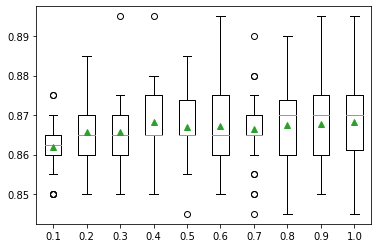

In [ ]:
# explore random forest bootstrap sample size on performance
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore ratios from 10% to 100% in 10% increments
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		# set max_samples=None to use 100%
		if i == 1.0:
			i = None
		models[key] = RandomForestClassifier(max_samples=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.862 (0.005)
>2 0.863 (0.008)
>3 0.865 (0.007)
>4 0.865 (0.009)
>5 0.866 (0.009)
>6 0.866 (0.012)
>7 0.866 (0.010)
>8 0.867 (0.010)
>9 0.867 (0.011)
>10 0.866 (0.010)
>11 0.868 (0.012)


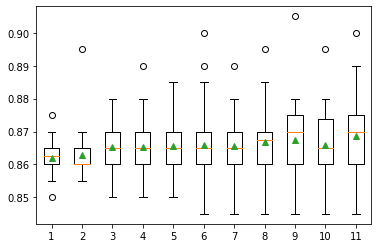

In [ ]:
# find best number of features based on accuarcy
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 7
	for i in range(1,12):
		models[str(i)] = RandomForestClassifier(max_features=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.627 (0.239)
>50 0.678 (0.266)
>100 0.719 (0.231)
>500 0.736 (0.261)
>1000 0.770 (0.255)


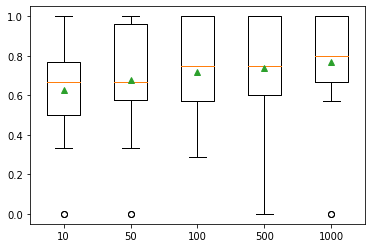

In [ ]:
#DO NOT RUN THIS IT TAKES FOREVER
# explore random forest number of trees effect on performance

# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
clf = RandomForestClassifier(class_weight = "balanced", max_features=10)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.861 (0.007)


In [ ]:
# View accuracy score
metrics.accuracy_score(y_test, y_pred)

0.864

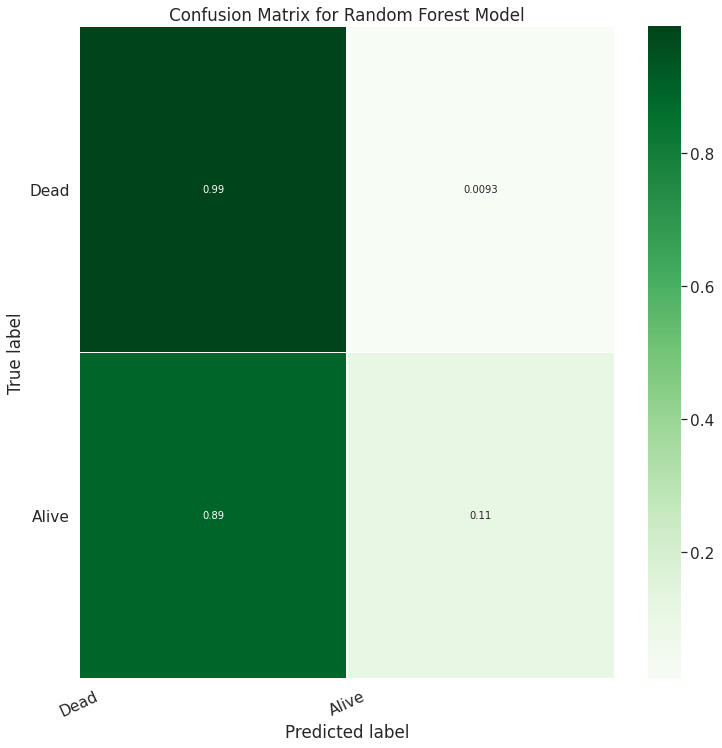

In [ ]:
import seaborn as sns

# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Dead', 'Alive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# View the classification report for test data and predictions
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.87      0.99      0.93       428
         1.0       0.67      0.11      0.19        72

    accuracy                           0.86       500
   macro avg       0.77      0.55      0.56       500
weighted avg       0.84      0.86      0.82       500



In [ ]:
print('test accuracy:', metrics.accuracy_score(y_test, y_pred))
print('test precision:', metrics.precision_score(y_test,y_pred))
print('test f1score:', metrics.f1_score(y_test,y_pred))
print('test auroc:', metrics.roc_auc_score(y_test,y_prob))
print('test recall:', metrics.recall_score(y_test, y_pred))

test accuracy: 0.864
test precision: 0.6666666666666666
test f1score: 0.1904761904761905
test auroc: 0.8372598650051921
test recall: 0.1111111111111111


In [ ]:
## TODO: write a funciton that calculates the following performance measures:
#     accuracy, F1-Score, AUROC, precision, sensitivity, and specificity.
#
import warnings
warnings.filterwarnings('ignore', category=exceptions.UndefinedMetricWarning)

def calculate_performance(clf_trained, X, y_true, metric='accuracy'):
    """
    Calculates the performance metric as evaluated on the true labels
    y_true versus the predicted scores from clf_trained and X.
    Input:
        clf_trained: a fitted instance of sklearn estimator
        X : (n,d) np.array containing features
        y_true: (n,) np.array containing true labels
        metric: string specifying the performance metric (default='accuracy'
                 other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
                 and 'specificity')
    Returns:
        the performance measure as a float
    """
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    if metric.lower() == 'accuracy':
        return metrics.accuracy_score(y_true, y_pred)
    elif metric.lower() == 'auroc':
        return metrics.roc_auc_score(y_true, y_prob)
    elif metric.lower() == 'f1_score' or metric.lower() == 'f1-score':
        return metrics.f1_score(y_true, y_pred)
    elif metric.lower() == 'precision':
        return metrics.precision_score(y_true, y_pred)
    elif metric.lower() == 'sensitivity':
        if tp + fn > 0:
            return tp / (tp+fn)
        else:
            return 0.0
    elif metric.lower() == 'specificity':
        if tn + fp > 0:
            return tn / (tn+fp)
        else:
            return 0.0
    else:
        raise NotImplementedError

In [ ]:
df_scores = pd.DataFrame(columns=['metric', 'score'])
for m in ['accuracy', 'f1-score', 'auroc', 'precision', 'sensitivity', 'specificity']:
    df_scores = df_scores.append([
        {'metric': m, 'score': calculate_performance(clf, X_test, y_test, metric=m)}
    ], ignore_index=True)
display(df_scores)

,metric,score
0,accuracy,0.854000
1,f1-score,0.160920
2,auroc,0.840943
3,precision,0.466667
4,sensitivity,0.097222
5,specificity,0.981308


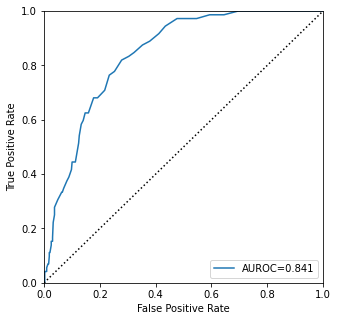

In [ ]:
# TODO: Plot ROC curve and calculate AUROC score
# ROC curve
fig, ax = plt.subplots(figsize=(5, 5))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='AUROC={:.3f}'.format(metrics.auc(fpr, tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], 'k:')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix

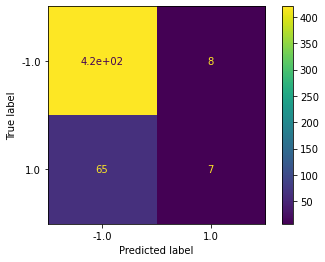

In [ ]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

Feature: 0, Score: 0.04328
Feature: 1, Score: 0.00271
Feature: 2, Score: 0.01234
Feature: 3, Score: 0.02326
Feature: 4, Score: 0.01524
Feature: 5, Score: 0.01148
Feature: 6, Score: 0.01420
Feature: 7, Score: 0.01506
Feature: 8, Score: 0.05588
Feature: 9, Score: 0.01445
Feature: 10, Score: 0.00243
Feature: 11, Score: 0.03811
Feature: 12, Score: 0.01596
Feature: 13, Score: 0.02092
Feature: 14, Score: 0.08037
Feature: 15, Score: 0.02583
Feature: 16, Score: 0.03589
Feature: 17, Score: 0.01914
Feature: 18, Score: 0.02771
Feature: 19, Score: 0.02187
Feature: 20, Score: 0.01940
Feature: 21, Score: 0.01756
Feature: 22, Score: 0.01912
Feature: 23, Score: 0.01901
Feature: 24, Score: 0.02097
Feature: 25, Score: 0.02369
Feature: 26, Score: 0.02149
Feature: 27, Score: 0.02926
Feature: 28, Score: 0.01701
Feature: 29, Score: 0.03011
Feature: 30, Score: 0.01222
Feature: 31, Score: 0.01067
Feature: 32, Score: 0.02217
Feature: 33, Score: 0.03124
Feature: 34, Score: 0.00473
Feature: 35, Score: 0.01105
Fe

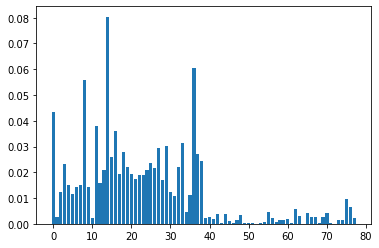

In [ ]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#Takes like 20 minutes to run
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=10,
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
             

In [ ]:
clf_random.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 2000}

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.2840 degrees.
Accuracy = 80.40%.


In [ ]:
best_random = clf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.2760 degrees.
Accuracy = 86.80%.


In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 7.96%.


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = base_model, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
#Takes like 15 minutes
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 11.3min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.2640 degrees.
Accuracy = 75.20%.


In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of -6.47%.


In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_random, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

KeyboardInterrupt: ignored

In [ ]:
y_pred = best_random.predict(X_test)
y_prob = best_random.predict_proba(X_test)[:, 1]

In [ ]:
print('test accuracy:', metrics.accuracy_score(y_test, y_pred))
print('test precision:', metrics.precision_score(y_test,y_pred))
print('test f1score:', metrics.f1_score(y_test,y_pred))
print('test auroc:', metrics.roc_auc_score(y_test,y_prob))
print('test recall:', metrics.recall_score(y_test, y_pred))

test accuracy: 0.862
test precision: 0.5384615384615384
test f1score: 0.3783783783783784
test auroc: 0.8598779854620977
test recall: 0.2916666666666667
